In [1]:
# -----------------------
# Step 1: Import Libraries
# -----------------------
import pandas as pd
import numpy as np
import pyodbc
from sqlalchemy import create_engine, text
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings("ignore")

In [2]:
# -----------------------
# Step 2: Database Connection
# -----------------------

server = '35.246.21.86'
database = 'TiorGames'
username = 'UoP007'
password = 'TIORGAMES_DB_PASSWORD'
connection_string = f'mssql+pyodbc://{username}:{password}@{server}/{database}?driver=ODBC+Driver+17+for+SQL+Server'

try:
    engine = create_engine(connection_string)
    with engine.connect() as conn:
        conn.execute(text("SELECT 1"))
        print("✅ Database connection successful.")
except Exception as e:
    print("❌ Failed to connect to the database.")
    print("Error:", e)
    exit()

✅ Database connection successful.


In [3]:
# -----------------------
# Step 3: Load External CSV
# -----------------------
df_external = pd.read_csv(r'C:\Users\Reena\OneDrive\Desktop\Kaplan\MSc\BI\External\ESport_Earnings.csv',encoding='latin1')

In [4]:
# -----------------------
# Step 4: Get League of Fun Summary from DB
# -----------------------

query = """
WITH TiorSummary AS (
    SELECT
        MIN(CAST(e.EventYear AS INT)) AS ReleaseYear,
        COUNT(DISTINCT e.EventID) AS TournamentNo,
        COUNT(DISTINCT pig.PlayerID) AS PlayerNo,
        (
            COALESCE(SUM(DISTINCT CAST(ef.MerchandiseSoldPND AS BIGINT)), 0) +
            COALESCE(SUM(DISTINCT CAST(ef.TicketsSoldPND AS BIGINT)), 0) +
            COALESCE(SUM(DISTINCT CAST(a.AwardValueInPND AS BIGINT)), 0)
        ) * 1.25 AS TotalMoney_USD
    FROM
        EventDim e
    LEFT JOIN EventFact ef ON ef.EventID = e.EventID
    LEFT JOIN AwardDim a ON a.AwardEventID = e.EventID
    LEFT JOIN GameFact gf ON gf.EventID = e.EventID
    LEFT JOIN PlayerInGameDim pig ON pig.GameID = gf.GameID
),

EventPrize AS (
    SELECT
        e.EventID,
        (
            COALESCE(ef.MerchandiseSoldPND, 0) +
            COALESCE(ef.TicketsSoldPND, 0) +
            COALESCE(a.AwardValueInPND, 0)
        ) * 1.25 AS PrizeMoney_USD
    FROM EventDim e
    LEFT JOIN EventFact ef ON ef.EventID = e.EventID
    LEFT JOIN AwardDim a ON a.AwardEventID = e.EventID
),

EventCountry AS (
    SELECT DISTINCT
        e.EventID,
        l.Country
    FROM
        PlayerInGameDim pig
    JOIN PlayerDim p ON pig.PlayerID = p.PlayerID
    JOIN LocationDim l ON p.PlayerOriginID = l.LocationID
    JOIN GameFact gf ON pig.GameID = gf.GameID
    JOIN EventDim e ON gf.EventID = e.EventID
),

EventCountryCount AS (
    SELECT
        EventID,
        COUNT(DISTINCT Country) AS CountryCount
    FROM EventCountry
    GROUP BY EventID
),

CountryEventShare AS (
    SELECT
        ec.Country,
        ep.PrizeMoney_USD / NULLIF(ecc.CountryCount, 0) AS CountryShare_USD
    FROM
        EventCountry ec
    JOIN EventPrize ep ON ec.EventID = ep.EventID
    JOIN EventCountryCount ecc ON ec.EventID = ecc.EventID
),

CountryEarnings AS (
    SELECT
        Country,
        SUM(CountryShare_USD) AS TotalEarnings_USD
    FROM CountryEventShare
    GROUP BY Country
),

TopCountry AS (
    SELECT TOP 1
        Country AS Top_Country,
        TotalEarnings_USD AS Top_Country_Earnings_USD
    FROM CountryEarnings
    ORDER BY TotalEarnings_USD DESC
)

SELECT
    1 AS IdNo,
    'League of Fun' AS GameName,
    'MOBA' AS Genre,
    ts.ReleaseYear,
    ts.TournamentNo,
    ts.PlayerNo,
    ts.TotalMoney_USD,
    tc.Top_Country,
    CAST(tc.Top_Country_Earnings_USD AS FLOAT) AS Top_Country_Earnings_USD
FROM TiorSummary ts
CROSS JOIN TopCountry tc;
"""

df_tior = pd.read_sql(query, engine)

In [5]:
# -----------------------
# Step 5: Merge + Clean Columns
# -----------------------

df_combined = pd.concat([df_external, df_tior], ignore_index=True)

# Standardize GameName
df_combined['GameName'] = df_combined['GameName'].str.strip()

# Consolidate metrics into final columns
df_combined['TotalMoney_Final'] = df_combined['TotalMoney_USD'].fillna(df_combined['TotalMoney'])
df_combined['Top_Country_Earnings_Final'] = df_combined['Top_Country_Earnings_USD'].fillna(df_combined['Top_Country_Earnings'])
df_combined['Release_Year_Final'] = df_combined['ReleaseYear'].fillna(df_combined['Releaseyear'])

# Drop unused columns
df_combined.drop(columns=[
    'TotalMoney_USD', 'Top_Country_Earnings_USD',
    'TotalMoney', 'Top_Country_Earnings',
    'Releaseyear', 'ReleaseYear'
], inplace=True)

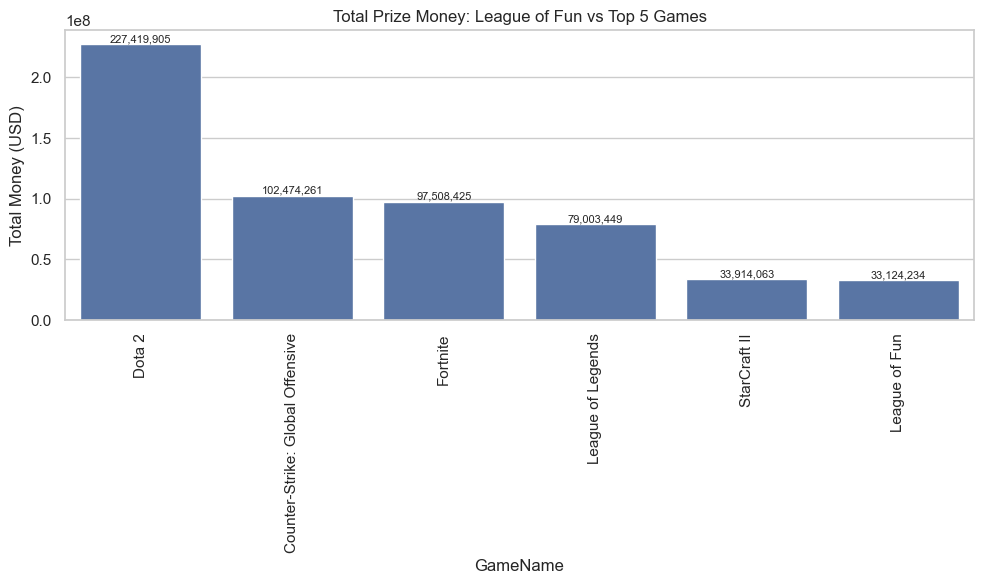

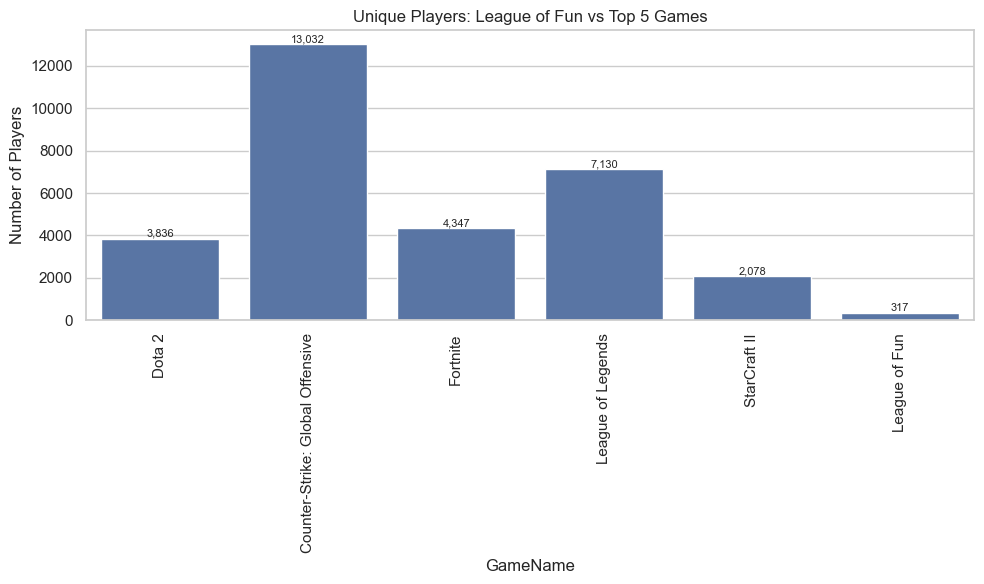

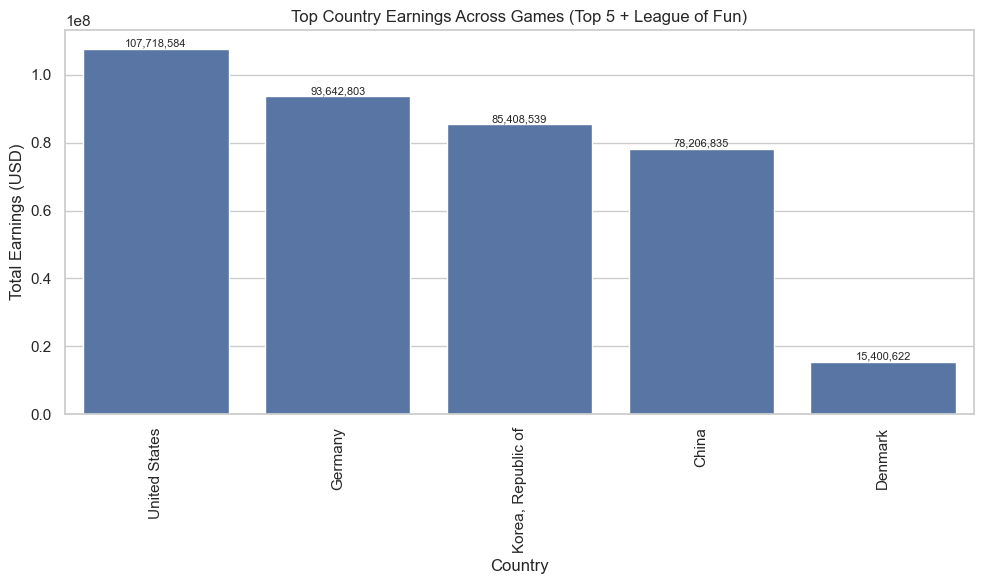

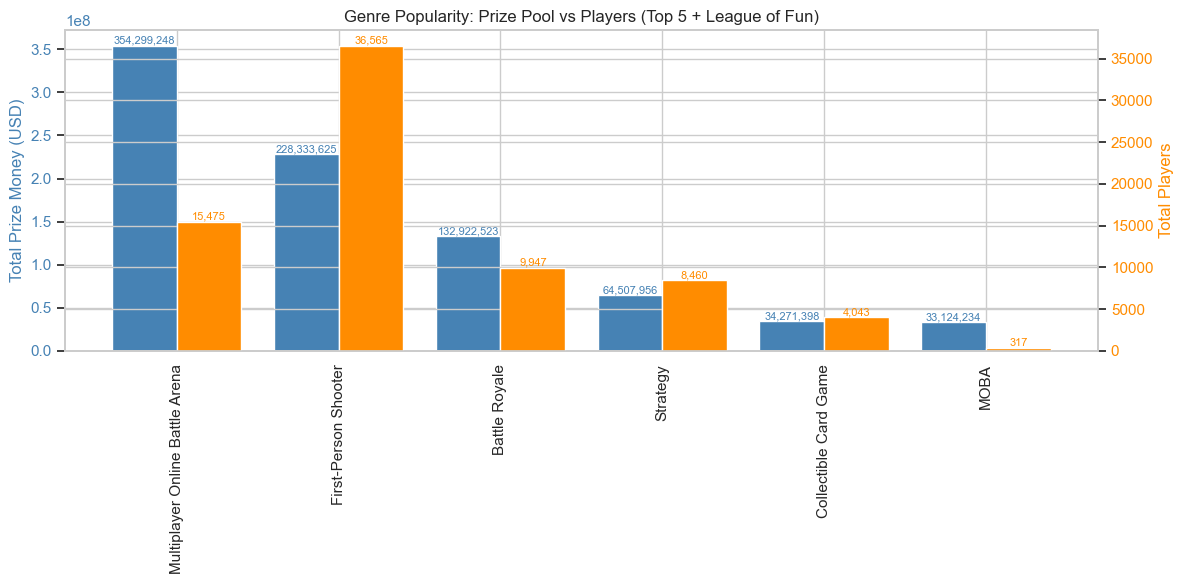

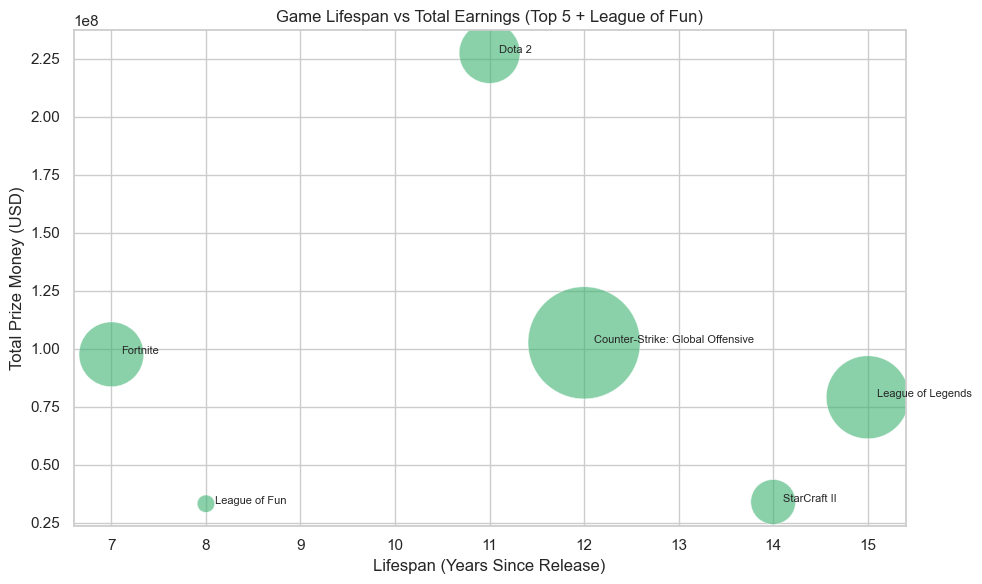

In [6]:
sns.set(style="whitegrid")

# -------------------------------
# Plot 1: Total Prize Money
# -------------------------------
top5 = df_combined[df_combined['GameName'] != 'League of Fun'].nlargest(5, 'TotalMoney_Final')
lof = df_combined[df_combined['GameName'] == 'League of Fun']
plot_df = pd.concat([top5, lof]).sort_values('TotalMoney_Final', ascending=False)

plt.figure(figsize=(10, 6))
ax = sns.barplot(x='GameName', y='TotalMoney_Final', data=plot_df)
plt.title("Total Prize Money: League of Fun vs Top 5 Games")
plt.ylabel("Total Money (USD)")
plt.xticks(rotation=90)
for p in ax.patches:
    ax.annotate(f'{p.get_height():,.0f}', (p.get_x() + p.get_width()/2, p.get_height()),
                ha='center', va='bottom', fontsize=8)
plt.tight_layout()
plt.show()


# -------------------------------
# Plot 2: Unique Players
# -------------------------------
plt.figure(figsize=(10, 6))
ax = sns.barplot(x='GameName', y='PlayerNo', data=plot_df)
plt.title("Unique Players: League of Fun vs Top 5 Games")
plt.ylabel("Number of Players")
plt.xticks(rotation=90)
for p in ax.patches:
    ax.annotate(f'{p.get_height():,.0f}', (p.get_x() + p.get_width()/2, p.get_height()),
                ha='center', va='bottom', fontsize=8)
plt.tight_layout()
plt.show()


# -------------------------------
# Plot 3: Top Country Earnings
# -------------------------------
country_agg = df_combined.groupby('Top_Country', as_index=False)['Top_Country_Earnings_Final'].sum()
top5_countries = country_agg.nlargest(5, 'Top_Country_Earnings_Final')
lof_country = df_combined[df_combined['GameName'] == 'League of Fun'][['Top_Country', 'Top_Country_Earnings_Final']]
lof_country = lof_country.groupby('Top_Country', as_index=False).sum()
top_countries = pd.concat([top5_countries, lof_country]).drop_duplicates('Top_Country')
top_countries = top_countries.sort_values(by='Top_Country_Earnings_Final', ascending=False)

plt.figure(figsize=(10, 6))
ax = sns.barplot(x='Top_Country', y='Top_Country_Earnings_Final', data=top_countries)
plt.title("Top Country Earnings Across Games (Top 5 + League of Fun)")
plt.ylabel("Total Earnings (USD)")
plt.xlabel("Country")
plt.xticks(rotation=90)
for p in ax.patches:
    ax.annotate(f'{p.get_height():,.0f}', (p.get_x() + p.get_width()/2, p.get_height()),
                ha='center', va='bottom', fontsize=8)
plt.tight_layout()
plt.show()


# -------------------------------
# Plot 4: Genre Popularity
# -------------------------------
# -------------------------------
# Plot 4: Genre Popularity (Top 5 + League of Fun)
# -------------------------------

# Aggregate total money and players by genre
genre_agg = df_combined.groupby('Genre', as_index=False)[['TotalMoney_Final', 'PlayerNo']].sum()

# Select top 5 genres by total prize money
top5_genres = genre_agg.nlargest(5, 'TotalMoney_Final')

# Add League of Fun's genre, even if it's not in top 5
lof_genre = df_combined[df_combined['GameName'] == 'League of Fun'][['Genre', 'TotalMoney_Final', 'PlayerNo']]
lof_genre = lof_genre.groupby('Genre', as_index=False).sum()

# Combine and ensure no duplicates
plot_data = pd.concat([top5_genres, lof_genre]).drop_duplicates('Genre')
plot_data = plot_data.sort_values(by='TotalMoney_Final', ascending=False)

# Setup plot
fig, ax1 = plt.subplots(figsize=(12, 6))
x = np.arange(len(plot_data))
bar_width = 0.4

# Left Y-axis: Total Prize Money
bars1 = ax1.bar(x, plot_data['TotalMoney_Final'], bar_width, color='steelblue', label='Total Prize Money (USD)')
ax1.set_ylabel('Total Prize Money (USD)', color='steelblue')
ax1.tick_params(axis='y', labelcolor='steelblue')

# Right Y-axis: Total Players
ax2 = ax1.twinx()
bars2 = ax2.bar(x + bar_width, plot_data['PlayerNo'], bar_width, color='darkorange', label='Total Players')
ax2.set_ylabel('Total Players', color='darkorange')
ax2.tick_params(axis='y', labelcolor='darkorange')

# X-axis labels (rotated 90 degrees)
ax1.set_xticks(x + bar_width / 2)
ax1.set_xticklabels(plot_data['Genre'], rotation=90)

# Title
plt.title("Genre Popularity: Prize Pool vs Players (Top 5 + League of Fun)")

# Add data labels for prize money
for i, bar in enumerate(bars1):
    ax1.text(bar.get_x() + bar.get_width()/2, bar.get_height(), f'{bar.get_height():,.0f}',
             ha='center', va='bottom', fontsize=8, color='steelblue')

# Add data labels for player count
for i, bar in enumerate(bars2):
    ax2.text(bar.get_x() + bar.get_width()/2, bar.get_height(), f'{bar.get_height():,.0f}',
             ha='center', va='bottom', fontsize=8, color='darkorange')

fig.tight_layout()
plt.show()



# -------------------------------
# Plot 5: Lifespan vs. Earnings (Bubble Chart)
# -------------------------------
df_combined['Lifespan'] = 2024 - df_combined['Release_Year_Final']
top5_games = df_combined[df_combined['GameName'] != 'League of Fun'].nlargest(5, 'TotalMoney_Final')
lof_row = df_combined[df_combined['GameName'] == 'League of Fun']
plot_data = pd.concat([top5_games, lof_row])

plt.figure(figsize=(10, 6))
plt.scatter(
    plot_data['Lifespan'],
    plot_data['TotalMoney_Final'],
    s=plot_data['PlayerNo'] * 0.5,
    alpha=0.6,
    c='mediumseagreen',
    edgecolors='w',
    linewidth=0.5
)

for i, row in plot_data.iterrows():
    plt.text(row['Lifespan'] + 0.1, row['TotalMoney_Final'], row['GameName'], fontsize=8)

plt.title("Game Lifespan vs Total Earnings (Top 5 + League of Fun)")
plt.xlabel("Lifespan (Years Since Release)")
plt.ylabel("Total Prize Money (USD)")
plt.grid(True)
plt.tight_layout()
plt.show()


In [7]:
df_external.head()

,IdNo,TotalMoney,GameName,Genre,PlayerNo,TournamentNo,Top_Country,Top_Country_Earnings,Releaseyear
0,613,310.00,Acceleration of SUGURI 2,Fighting Game,6,2,United States,310.00,2018
1,510,190075.61,Age of Empires,Strategy,246,95,Viet Nam,123408.43,1997
2,179,1492489.51,Age of Empires II,Strategy,956,576,China,174252.44,1999
3,177,68113.85,Age of Empires III,Strategy,106,76,United States,18523.52,2005
4,540,2668.00,Age of Empires Online,Strategy,16,7,Germany,1264.00,2011


In [8]:
df_combined.head()

,IdNo,GameName,Genre,PlayerNo,TournamentNo,Top_Country,TotalMoney_Final,Top_Country_Earnings_Final,Release_Year_Final,Lifespan
0,613,Acceleration of SUGURI 2,Fighting Game,6,2,United States,310.00,310.00,2018.0,6.0
1,510,Age of Empires,Strategy,246,95,Viet Nam,190075.61,123408.43,1997.0,27.0
2,179,Age of Empires II,Strategy,956,576,China,1492489.51,174252.44,1999.0,25.0
3,177,Age of Empires III,Strategy,106,76,United States,68113.85,18523.52,2005.0,19.0
4,540,Age of Empires Online,Strategy,16,7,Germany,2668.00,1264.00,2011.0,13.0
